# NLP Model Evaluation 

In this notebook, we will evaluate three models for the NLP component of Gredient. We will use self-collected data that contains images and annotations of product safety, given a set of allergens. Since Textract has been proven to do well on time and accuracy, we will move forward with evaluating NLP models on detections from Textract. 

The three models are (1) a perfect matching mechanism, (2) cosine similarity with CountVectorizer character embeddings, and (3) cosine similarity with Chars2Vec character embeddings. For the latter two, we tune the threshold of the cosine similarity scores to observe which setting would result in an acceptable balance between the true positive rate and the false positive rate. When the threshold is higher, the model makes fewer matches between allergens and ingredients, and thus has an increased false positive rate. Basic match represents the accuracy metrics at the highest threshold, where the cosine similarity score equals 1. 

A true positive takes place when the model correctly signals a product to be safe, since there are no ingredient and allergen matches. On the other hand, a false positive is when a model signals a product to be safe when it is actually unsafe.   



### Import some libraries...

In [38]:
import boto3 
import botocore 
from sagemaker import get_execution_role 

import PIL
from PIL import Image
import s3fs
from io import BytesIO

import pandas as pd
import numpy as np
import re 
import string
import time

import chars2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

### Connect to S3 and read data...

In [2]:
# read true safety annotations
role = get_execution_role() 
data_location = 's3://{}/{}'.format('sagemaker-060720', 'true_safety.csv') 
true_safety = pd.read_csv(data_location)

In [3]:
# read images and file names
file_names = []
imgs = []

fs = s3fs.S3FileSystem()
for img_path in fs.ls('s3://sagemaker-060720/Images/'):
    file_name = img_path[24:]
    file_names.append(file_name)
    with fs.open(f's3://'+img_path) as f:
        pil_img = Image.open(f)
        buff = BytesIO()
        pil_img.save(buff, format="JPEG")
        img_bytes = buff.getvalue()
        imgs.append(img_bytes)
    

### Preprocess for NLP...

In [4]:
# add allergens column 
true_safety['allergens'] = "na"

isaac = 'milk, cheese, soy, cream, eggs'
jj = 'peanuts, whey, tree nuts'
chelsea = 'Shrimp, Prawns, Lobster, Crab'
emma = 'wheat, barely, rye triticale'
silvia = 'garlic, avocado, celery'

true_safety.loc[0:10, 'allergens'] = emma
true_safety.loc[10:21, 'allergens'] = silvia
true_safety.loc[21:45, 'allergens'] = isaac
true_safety.loc[45:55, 'allergens'] = jj
true_safety.loc[55:65, 'allergens'] = chelsea

In [5]:
print(true_safety.shape)
true_safety.head()

(65, 4)


,Item,Name,Label,allergens
0,0,emma-1.jpg,0,"wheat, barely, rye triticale"
1,1,emma-2.jpg,0,"wheat, barely, rye triticale"
2,2,emma-3.jpg,0,"wheat, barely, rye triticale"
3,3,emma-4.jpg,0,"wheat, barely, rye triticale"
4,4,emma-5.jpg,1,"wheat, barely, rye triticale"


In [6]:
# allergens and labels corresponding to images
allergens = []
labels = []

for file_name in file_names:
    
    true_vals = true_safety.loc[true_safety.Name == file_name,]
    
    allgs = true_vals.allergens.values[0]
    allergens.append(allgs)
    
    label = true_vals.Label.values[0]
    labels.append(label)

In [7]:
# Textract detections 
detected = []

for img in imgs:

    tex_client = boto3.client('textract')
    tex_dect = tex_client.detect_document_text(Document={"Bytes":img})

    tex_text = [text['Text'] if text['BlockType']=='WORD' else "" for text in tex_dect['Blocks']]
    detected.append(tex_text)    

### Helpful Functions

In [8]:
# clean words 
def clean_word (word):
    
    c_word = word.lower().strip() # lowercase and remove white space
    c_word = re.sub('[^a-zA-Z]+', '', c_word) # remove anything that's not a letter
    if len(c_word) < 2: # remove words that are less than 2 characters
        c_word = "" 
    
    return c_word

# clean string of words
def clean_text (text, split=True):
    
    if split == False: # for ocr output
        c_text = [clean_word(w) for w in text] # already split and clean words
        
    else: 
        c_text = re.sub('[0-9]', ' ', text) # replace numbers with space 
        c_text = re.sub('['+string.punctuation+']', ' ', c_text) # replace punctuation with space
        c_text = [clean_word(w) for w in c_text.split()] # split on spaces and clean words
      
    c_text = sorted(list(filter(None, set(c_text)))) # remove empty words and get unique values and sort
    
    return c_text

In [45]:
# positive: safe ; negative: unsafe
# true positives: #(classified safe products that are actually safe) 
# false positives: #(classified safe products that are actually unsafe) <- NOT GOOD 
# true negatives: #(classified unsafe products that are actually unsafe)
# false negatives: #(classified unsafe products that are actually safe)

def pred_stats(pred_safety, true_safety):
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(pred_safety)):
        if (pred_safety[i]=="safe") & (true_safety[i]==1):
            tp += 1
        if (pred_safety[i]=="safe") & (true_safety[i]==0):
            fp += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]==0):
            tn += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]==1):
            fn += 1
    
    if tp == 0:
        p = 0
        r = 0
        f1score = 0
    else: 
        p = tp/(tp+fp)
        r = tp/(tp+fn)
        f1score = (2*p*r)/(p+r)
        
    return [tp,fp,tn,fn,p,r,f1score]

In [55]:
# sensitivity = recall =  tp/(tp+fn) : true safe detections out of all safe
def tpr(tex_scores): 
    return [scores[5] for scores in tex_scores]
  
# 1-specificity = false positive rate = fp/(fp+tn) : false safe detections out of all unsafe
def fpr(tex_scores):
    return [scores[1]/(scores[1]+scores[2]) for scores in tex_scores if (scores[1]+scores[2])!=0]
    
# (0:tp, 1:fp, 2:tn, 3:fn, 4:p, 5:r, 6:f1score) 

In [10]:
# detect the safety of ingredients for a given similarity score 
def dect_safety(safety_func, sim):  
    
    start_time = time.time()
    
    safety = [safety_func(allgs, ings, sim) for allgs,ings in zip(clean_allergens, clean_detected)]
    
    t_time = (time.time() - start_time)/65
    print("--- %s seconds ---" % t_time)
    
    return [safety, t_time]

### Cleaned list of detections and allergens

In [11]:
clean_detected = [clean_text(tex_text, split=False) for tex_text in detected]
clean_allergens = [clean_text(allgs) for allgs in allergens]

## Perfect Match 

In [12]:
# apply perfect matching
def safety_perfect (allergens, ingredients): 
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else: 
        ocr_safety = [a in ingredients for a in allergens] # creates boolean array of presence of allergen in ingredients
        if sum(ocr_safety) > 0:
            return "unsafe"
        else: return "safe"

In [13]:
start_time = time.time()

perfect_safety = [safety_perfect(allgs, ings) for allgs,ings in zip(clean_allergens, clean_detected)]

print("--- %s seconds ---" % ((time.time() - start_time)/(65))) # 6.939814640925481e-06 seconds

--- 6.939814640925481e-06 seconds ---


In [46]:
perfect_scores = pred_stats(perfect_safety, labels)
perfect_scores

# [37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938]

[37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938]

## CountVectorizer

In [15]:
def safety_count (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else:
        vectorizer = CountVectorizer(analyzer='char')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = vectorizer.fit_transform(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe" 
        else: return "safe" 

In [ ]:
count_sims = [0.60, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
count_safety = [dect_safety(safety_count, sim) for sim in count_sims]

In [21]:
count_safe = [count_s[0] for count_s in count_safety] # detected safety for each cosine threshold
print(sum([count_s[1] for count_s in count_safety])/len(count_sims)) # average time: 0.002580

0.002580121113703801


In [47]:
count_scores = [pred_stats(count_safe[i], labels) for i in range(len(count_sims))] # scores for each cosine
count_scores

#[[12, 1, 25, 26, 0.9230769230769231, 0.3157894736842105, 0.47058823529411764],
# [23, 1, 25, 15, 0.9583333333333334, 0.6052631578947368, 0.7419354838709677],
# [28, 2, 24, 10, 0.9333333333333333, 0.7368421052631579, 0.8235294117647058],
# [33, 2, 24, 5, 0.9428571428571428, 0.868421052631579, 0.904109589041096],
# [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935]]

[[12, 1, 25, 26, 0.9230769230769231, 0.3157894736842105, 0.47058823529411764],
 [23, 1, 25, 15, 0.9583333333333334, 0.6052631578947368, 0.7419354838709677],
 [28, 2, 24, 10, 0.9333333333333333, 0.7368421052631579, 0.8235294117647058],
 [33, 2, 24, 5, 0.9428571428571428, 0.868421052631579, 0.904109589041096],
 [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935]]

## Chars2Vec

In [18]:
def safety_chars (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo."
    else:
        c2v_model = chars2vec.load_model('eng_50')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = c2v_model.vectorize_words(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe"
        else: return "safe"

In [ ]:
chars_sims = [0.75, 0.80, 0.85, 0.90, 0.95]
chars_safety = [dect_safety(safety_chars, sim) for sim in chars_sims]

In [22]:
chars_safe = [chars_s[0] for chars_s in chars_safety] # detected safety for all ingredients for every cosine threshold
print(sum([chars_s[1] for chars_s in chars_safety])/len(chars_sims)) # average time: 2.40915

2.4091517800551197


In [48]:
chars_scores = [pred_stats(chars_safe[i], labels) for i in range(len(chars_sims))] # scores for each cosine
chars_scores

#[[17, 0, 26, 21, 1.0, 0.4473684210526316, 0.6181818181818182],
# [24, 1, 25, 14, 0.96, 0.631578947368421, 0.7619047619047619],
# [30, 2, 24, 8, 0.9375, 0.7894736842105263, 0.8571428571428572],
# [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935],
# [37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938]]

[[17, 0, 26, 21, 1.0, 0.4473684210526316, 0.6181818181818182],
 [24, 1, 25, 14, 0.96, 0.631578947368421, 0.7619047619047619],
 [30, 2, 24, 8, 0.9375, 0.7894736842105263, 0.8571428571428572],
 [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935],
 [37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938]]

## ROC and AUC

For different thresholds of the cosine similarity score, we can draw an ROC curve to determine the best threshold for the tradeoff we are willing to accept. We can also compare CountVectorizer and Chars2Vec based on their AUC.

In [56]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "sans-serif"

def plotROC (scores1, scores2, scores3):
    
    x1 = fpr(scores1)
    y1 = tpr(scores1)

    x2 = fpr(scores2)
    y2 = tpr(scores2)

    fig, ax = plt.subplots(figsize=(8,5))
    
    x3 = scores3[1]/(scores3[1]+scores3[2])
    y3 = scores3[5]

    plt.ylabel("True Positive Rate", color="#447b72", weight="bold")
    plt.yticks(fontsize=12, color="#234943")
    plt.xlabel("False Positive Rate", color="#447b72", weight="bold")
    plt.xticks(fontsize=12, color="#234943")
    #plt.title("All Images")

    plt.plot(x3, y3, 'Db', label='Basic Match', alpha=0.75)
    plt.plot(x1, y1, 'c', label='CountVectorizer')
    plt.plot(x2, y2, 'y', label='Chars2Vec')
    plt.plot(x3, y3, 'Db')

    legend = ax.legend(loc='upper left', edgecolor='#447b72', shadow=True, prop={'weight':'bold', 'size':10})
    frame = legend.get_frame()
    frame.set_facecolor("white")
    
    for text in legend.get_texts():
        text.set_color("#447b72")

    verts1 = [(x1[0], 0), *zip(x1, y1), (x1[4], 0)]
    poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5', color="c", alpha=0.1)
    ax.add_patch(poly1)

    verts2 = [(x2[0], 0), *zip(x2, y2), (x2[4], 0)]
    poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5', color="y", alpha=0.1)
    ax.add_patch(poly2)
    
    fig.set_facecolor('white')
    ax.set_facecolor("white")

#     for i, txt in enumerate(s):
#         ax.annotate(txt, (x1[i], y1[i]+0.02), fontsize=10)
#         ax.annotate(txt, (x2[i], y2[i]-0.02), fontsize=10)

    return plt

<ipython-input-56-0088410dc1ff>:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5', color="c", alpha=0.1)
<ipython-input-56-0088410dc1ff>:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5', color="y", alpha=0.1)


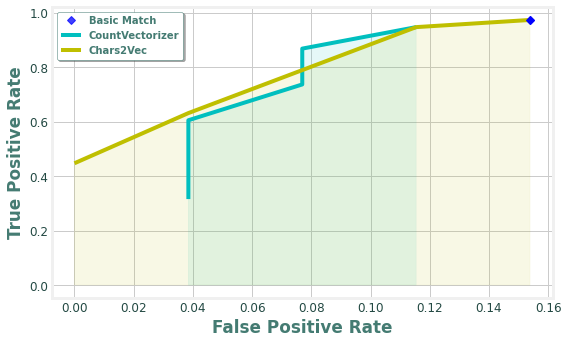

In [57]:
plt = plotROC(count_scores, chars_scores, perfect_scores) # top ingredients 

plt.show()

In [ ]:
results = []

tp = 0
fp = 0
tn = 0
fn = 0

fs = s3fs.S3FileSystem()
for img_path in fs.ls('s3://sagemaker-060720/Images/'):
    
    file_name = img_path[24:]
    true_vals = true_safety.loc[true_safety.Name == file_name,]
    label = true_vals.Label.values[0]
    allergens = true_vals.allergens.values[0]
    
    with fs.open(f's3://'+img_path) as f:
        
        pil_img = Image.open(f)

        
        buff = BytesIO()
        pil_img.save(buff, format="JPEG")
        img_bytes = buff.getvalue()
        
        tex_client = boto3.client('textract')
        tex_dect = tex_client.detect_document_text(Document={"Bytes":img_bytes})
        
        tex_text = [text['Text'] if text['BlockType']=='WORD' else "" for text in tex_dect['Blocks']]
        
        tex_ingredients = clean_text(tex_text, split=False)
        
        clean_allergens = clean_text(allergens)
        
#         tex_results = safety(clean_allergens, tex_ingredients)

#         results.append(tex_results)
        
#         tex_safety = tex_results['result']

        tex_safety = safety_count(clean_allergens, tex_ingredients)
        
        if (tex_safety=="safe") & (label==1):
            tp += 1
        if (tex_safety=="safe") & (label==0):
            fp += 1
        if (tex_safety=="unsafe") & (label==0):
            tn += 1
        if (tex_safety=="unsafe") & (label==1):
            fn += 1

print(tp, fp, tn, fn)

In [ ]:


# safety of product
def safety (allergens, ingredients):
    vectorizer = CountVectorizer(analyzer='char')
    if len(ingredients) == 0 or ingredients == ['']:
        return { "ocr": ingredients,
                 "target": allergens,
                 "matchy": "Nothing detected.",
                 "result": "Nothing detected. Please retake photo." }
    else:
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = vectorizer.fit_transform(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > 0.85] # counts of ingredients with a 0.75 greater cos sim to each allergen 
        b = [c!=0 for c in counts] # boolean of counts
        matches = np.array(allergens)[b] # dangerous ingredients
        if sum(counts) > 0:
            return { "ocr": ingredients,
                     "target": allergens,
                     "matchy": list(matches),
                     "result": "unsafe" }
        else: return { "ocr": ingredients,
                       "target": allergens,
                       "matchy": "None of the ingredients match your allergens.",
                       "result": "safe" }

In [ ]:
def safety_chars (allergens, ingredients):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo."
    else:
        c2v_model = chars2vec.load_model('eng_50')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = c2v_model.vectorize_words(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > 0.75] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe"
        else: return "safe"
        
def safety_count (allergens, ingredients):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else:
        vectorizer = CountVectorizer(analyzer='char')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = vectorizer.fit_transform(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > 0.75] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe" 
        else: return "safe" 

In [ ]:
p = tp/(tp+fp)
r = tp/(tp+fn)
if p==0 and r==0:
    f1score = 0
else: f1score = (2*p*r)/(p+r)

In [ ]:
f1score

In [ ]:
r

In [ ]:
fp/(fp+tn)

In [ ]:
28 2 24 10 | 30 2 24 8

0.8235294117647058 | 0.8571428571428572

0.7368421052631579 | 0.7894736842105263

0.07692307692307693 | 0.07692307692307693


12 1 25 26 | 

In [ ]:
# detect the safety of ingredients for a given similarity score 
def dect_safety(safety_func, sim):  
    
    start_time = time.time()
    
    top_safety = [[safety_func(person, ing, sim) for ing in top_tex_ings] for person in allergens] # detected safety for top ingredients
    all_safety = [[safety_func(person, ing, sim) for ing in tex_ingredients] for person in allergens] # detected safety for all ingredients
    
    t_time = (time.time() - start_time)/(1210*5)
    print("--- %s seconds ---" % t_time)
    
    return [top_safety, all_safety, t_time]

In [ ]:
# positive: safe ; negative: unsafe
# true positives: #(classified safe products that are actually safe) 
# false positives: #(classified safe products that are actually unsafe) <- NOT GOOD 
# true negatives: #(classified unsafe products that are actually unsafe)
# false negatives: #(classified unsafe products that are actually safe)

def pred_stats(pred_safety, true_safety):
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(pred_safety)):
        if (pred_safety[i]=="safe") & (true_safety[i]=="safe"):
            tp += 1
        if (pred_safety[i]=="safe") & (true_safety[i]=="unsafe"):
            fp += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]=="unsafe"):
            tn += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]=="safe"):
            fn += 1
            
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    if p==0 and r==0:
        f1score = 0
    else: f1score = (2*p*r)/(p+r)
        
    return(tp,fp,tn,fn,p,r,f1score)

In [ ]:
person_A = ['milk', 'cheese', 'soy', 'cream', 'eggs']
person_B = ['peanuts', 'whey', 'tree nuts']
person_C = ['Shrimp', 'Prawns', 'Lobster', 'Crab']
person_D = ['wheat', 'barely', 'rye triticale']
person_E = ['garlic', 'avocado', 'celery']

allergens = [person_A, person_B, person_C, person_D, person_E]

In [ ]:
# boolean of presence of allergens
top_bool_safety = [[[a in ing for a in person] for ing in a_tex_ings] for person in allergens] # for top ingredients 
bool_safety = [[[a in ing for a in person] for ing in ingredients] for person in allergens] # for all ingredients 

# true safety of each product
top_true_safety = [["unsafe" if sum(s)>0 else "safe" for s in person] for person in top_bool_safety]
true_safety = [["unsafe" if sum(s)>0 else "safe" for s in person] for person in bool_safety] 

print(len(top_true_safety[0]))
print(len(true_safety[0]))

In [ ]:
# actual safety for persons 
print("top safe", [sum([s == "safe" for s in person]) for person in top_true_safety], "top unsafe", [sum([s == "unsafe" for s in person]) for person in top_true_safety])
print("all safe", [sum([s == "safe" for s in person]) for person in true_safety], "all unsafe", [sum([s == "unsafe" for s in person]) for person in true_safety])


In [ ]:
top_tex_ings = top_tex_ingredients[2] # top detected ingredients
#tex_ingredients <- all detected ingredients 

# Basic

In [ ]:
# apply perfect matching
def safety_basic (allergens, ingredients): 
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else: 
        ocr_safety = [a in ingredients for a in allergens] # creates boolean array of presence of allergen in ingredients
        if sum(ocr_safety) > 0:
            return "unsafe"
        else: return "safe"

In [ ]:
start_time = time.time()

top_basic_safety = [[safety_basic(person, ing) for ing in top_tex_ings] for person in allergens] # detected safety for top ingredients for each person
basic_safety = [[safety_basic(person, ing) for ing in tex_ingredients] for person in allergens] # detected safety for all ingredients for each person

print("--- %s seconds ---" % ((time.time() - start_time)/(1210*5))) # 0.000003

In [ ]:
print(len(top_basic_safety[0]))
print(len(basic_safety[0]))

In [ ]:
top_basic_scores = [pred_stats(top_basic_safety[i], top_true_safety[i]) for i in range(5)] # scores for top ingredients for each person 
basic_scores = [pred_stats(basic_safety[i], true_safety[i]) for i in range(5)] # scores for all ingredients for each person 

print(len(top_basic_scores[0]))
print(len(basic_scores[0]))

# Count

In [ ]:
def safety_count (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else:
        vectorizer = CountVectorizer(analyzer='char')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = vectorizer.fit_transform(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe" 
        else: return "safe" 

In [ ]:
count_sims = [0.75, 0.80, 0.85, 0.90, 0.95]
count_safes = [dect_safety(safety_count, sim) for sim in count_sims]
top_count_safety = [count_s[0] for count_s in count_safes] # detected safety for top ingredients for every cosine threshold
count_safety = [count_s[1] for count_s in count_safes] # detected safety for all ingredients for every cosine threshold
print(sum([count_s[2] for count_s in count_safes])/5) # 0.00230

In [ ]:
print(len(top_count_safety[0][0]))
print(len(count_safety[0][0]))

In [ ]:
top_count_scores = [[pred_stats(top_count_safety[s][i], top_true_safety[i]) for i in range(5)] for s in range(5)] # scores for top ingredients for each cosine and each person
count_scores = [[pred_stats(count_safety[s][i], true_safety[i]) for i in range(5)] for s in range(5)] # scores for top ingredients for each cosine and each person

print(len(top_count_scores[0][0]))
print(len(count_scores[0][0]))

# Chars

In [ ]:
def safety_chars (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo."
    else:
        c2v_model = chars2vec.load_model('eng_50')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = c2v_model.vectorize_words(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe"
        else: return "safe"

In [ ]:
safety_chars[person_A, top_tex_ings, 0.85]

In [ ]:
chars_sims = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
chars_safes = [dect_safety(safety_chars, sim) for sim in chars_sims]
top_chars_safety = [chars_s[0] for chars_s in chars_safes] # detected safety for top ingredients for every cosine threshold
chars_safety = [chars_s[1] for chars_s in chars_safes] # detected safety for top ingredients for every cosine threshold
print(sum([chars_s[2] for chars_s in chars_safes])/5) # 0.000956

In [ ]:
print(len(top_chars_safety[0][0]))
print(len(chars_safety[0][0]))

In [ ]:
top_chars_scores = [[pred_stats(top_chars_safety[s][i], top_true_safety[i]) for i in range(5)] for s in range(5)] # scores for top ingredients for each cosine and each person
chars_scores = [[pred_stats(chars_safety[s][i], true_safety[i]) for i in range(5)] for s in range(5)] # scores for top ingredients for each cosine and each person

print(len(top_chars_scores[0][0]))
print(len(chars_scores[0][0]))

# ROC AUC 

For different thresholds of the cosine similarity score, we can draw an ROC curve to determine the best threshold for the tradeoff we are willing to accept. We can also decide to use CountVectorizer or Chars2Vec based on which one has a greater AUC.

In [ ]:
# sensitivity = recall =  tp/(tp+fn) : true safe detections out of all safe
def tpr(tex_scores): 
    return [sum([scores[5] for scores in tex_scores[i]])/5 for i in range(5)]
  
# 1-specificity = false positive rate = fp/(fp+tn) : false safe detections out of all unsafe
def fpr(tex_scores):
    return [sum([scores[1]/(scores[1]+scores[2]) for scores in tex_scores[i] if (scores[1]+scores[2])!=0])/5 for i in range(5)]
    
# (0:tp, 1:fp, 2:tn, 3:fn, 4:p, 5:r, 6:f1score) 

In [ ]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "sans-serif"

def plotROC (tex_scores1, tex_scores2, tex_scores3):
    
    x1 = fpr(tex_scores1)
    y1 = tpr(tex_scores1)

    x2 = fpr(tex_scores2)
    y2 = tpr(tex_scores2)

    fig, ax = plt.subplots(figsize=(8,5))
    
    x3 = sum([scores[1]/(scores[1]+scores[2]) for scores in tex_scores3 if (scores[1]+scores[2])!=0])/5
    y3 = sum([scores[5] for scores in tex_scores3])/5

    plt.ylabel("True Positive Rate", color="#447b72", weight="bold")
    plt.yticks(fontsize=12, color="#234943")
    plt.xlabel("False Positive Rate", color="#447b72", weight="bold")
    plt.xticks(fontsize=12, color="#234943")
    #plt.title("All Images")

    plt.plot(x3, y3, 'Db', label='Basic Match', alpha=0.75)
    plt.plot(x1, y1, 'c', label='CountVectorizer')
    plt.plot(x2, y2, 'y', label='Chars2Vec')
    plt.plot(x3, y3, 'Db')

    legend = ax.legend(loc='upper left', edgecolor='#447b72', shadow=True, prop={'weight':'bold', 'size':10})
    frame = legend.get_frame()
    frame.set_facecolor("white")
    
    for text in legend.get_texts():
        text.set_color("#447b72")

    verts1 = [(x1[0], 0), *zip(x1, y1), (x1[4], 0)]
    poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5', color="c", alpha=0.1)
    ax.add_patch(poly1)

    verts2 = [(x2[0], 0), *zip(x2, y2), (x2[4], 0)]
    poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5', color="y", alpha=0.1)
    ax.add_patch(poly2)
    
    fig.set_facecolor('white')
    ax.set_facecolor("white")

#     for i, txt in enumerate(s):
#         ax.annotate(txt, (x1[i], y1[i]+0.02), fontsize=10)
#         ax.annotate(txt, (x2[i], y2[i]-0.02), fontsize=10)

    return plt

In [ ]:
plt = plotROC(top_count_scores, top_chars_scores, top_basic_scores) # top ingredients 

plt.show()

In [ ]:
plt = plotROC(count_scores, chars_scores, basic_scores) # all ingredients 

plt.show()